# Supervised learning with sklearn
**Bosun Anifowoshe**

bosunani@gmail.com

This file will provide analysis for 5 different classification algorithms for two datasets.

Datasets: Magic Telescope, Phishing Websites.

Classification Algorithms: Decision Tree, Neural Network, Boosting, SVM, KNN.

There will be two outputs for each model: a plot of learning curve and a plot of model complexity. Both plots will be generated after hyperparameter tuning is performed.

# 1. Data Load and Preprocessing

First we load the data! Please save the datasets to your local machine and change the current directory to a file where you have the data stored.

In [2]:
import os
import pandas as pd
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

### Load the Magic Telescope Data

In [6]:
df_MT = pd.read_csv('MagicTelescope.csv')
print("Data has",len(df_MT),"rows and", len(df_MT.columns),"columns.")
if df_MT.isnull().values.any():
    print("Warning: Missing Data")
df_MT.describe(include='all')

Data has 19020 rows and 11 columns.


,class,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,0.351630,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026
std,0.477492,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787
min,0.000000,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,0.000000,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250
50%,0.000000,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450
75%,1.000000,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825
max,1.000000,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


No preprocessing is needed for this data set and it is good to go.

### Load the Phishing Website Data

In [7]:
## Download the Phishing Data from OpenML https://www.openml.org/d/4534

df_PW = pd.read_csv('PhishingWebsites.csv').astype('category')
print("Data has",len(df_PW),"rows and", len(df_PW.columns),"columns.")
if df_PW.isnull().values.any():
    print("Warning: Missing Data")

Data has 11055 rows and 31 columns.


This data need some preprocessing. Several of the columns are categorical with the levels {-1,0,1} and the rest are all binary with levels {-1,1}. For the 3-level columns we will use one-hot encoding to create additional features with level {0,1}. Finally, we will edit the binary features so that the new levels are all {0,1}. We will have more features now, but they will all be binary.

In [8]:
col_1hot = ['URL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
df_1hot = df_PW[col_1hot]
df_1hot = pd.get_dummies(df_1hot)
df_others = df_PW.drop(col_1hot,axis=1)
df_PW = pd.concat([df_1hot,df_others],axis=1)
df_PW = df_PW.replace(-1,0).astype('category')
column_order = list(df_PW)
column_order.insert(0, column_order.pop(column_order.index('Result')))
df_PW = df_PW.loc[:, column_order]  #move the target variable 'Result' to the front
df_PW.describe(include='all')

,Result,URL_Length_-1,URL_Length_0,URL_Length_1,having_Sub_Domain_-1,having_Sub_Domain_0,having_Sub_Domain_1,SSLfinal_State_-1,SSLfinal_State_0,SSLfinal_State_1,...,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,Page_Rank,Google_Index,Statistical_report
count,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,...,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,1,1,0,0,0,0,0,0,0,1,...,0,1,1,1,1,1,1,0,1,1
freq,6157,8960,10920,9095,7692,7433,6985,7498,9888,6331,...,9776,9740,10579,8918,10043,5866,7612,8201,9516,9505


We now have a file with no missing data in the format [y, X] where all features are binary {0,1}. The phishing data is ready to go!

Now we have successfully loaded and processed both datasets. We are ready to start the ML!

# 2. Helper Functions

### Data Loading and Function Prep

Before we get into the algorithms, let's define some helper functions that will be used across all of the models and both datasets. We will define a function to load the data (not really necessary in a Jupyter notebook, but good if this is exported as a .py for later use). We will also define a function that plots the learning curve (training and cross validation score as a function of training examples) of an estimator (classification model). Finally, we define functions to output final model scores using an untouched test dataset.

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, r2_score 
from sklearn.preprocessing import StandardScaler, normalize
import itertools
import timeit

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 12

def import_data():

    X1 = np.array(df_MT.values[:,1:-1],dtype='int64')
    Y1 = np.array(df_MT.values[:,0],dtype='int64')
    X2 = np.array(df_PW.values[:,1:-1],dtype='int64')
    Y2 = np.array(df_PW.values[:,0],dtype='int64')
    return X1, Y1, X2, Y2


def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='r2', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean, cv_mean
    

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(train_sizes, train_mean, 'o-', color="black", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="grey", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.plot(train_sizes, fit_mean, 'o-', color="black", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="grey", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Greys):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    #auc = roc_auc_score(y_test, y_pred)
    #f1 = f1_score(y_test,y_pred)
    #accuracy = accuracy_score(y_test,y_pred)
    #precision = precision_score(y_test,y_pred)
    #recall = recall_score(y_test,y_pred)
    #cm = confusion_matrix(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("r2:  "+"{:.2f}".format(r2))
    #print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    #print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    #plt.figure()
    #plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    #plt.show()

# 3. The Fun Part: Machine Learning!

# Decision Tree Classifier

This section will build a Decision Tree Classifier using information gain (based on entropy) to determine the best feature split per the ID3 algorithm. The model will be pre-pruned by limiting tree depth using the hyperparameter 'max_depth' and by ensuring that each leaf (a terminal node on the tree) has at least 'min_samples_leaf'. 

In [11]:
from sklearn.tree import DecisionTreeClassifier

def hyperTree(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    max_depth = list(range(1,31))
    for i in max_depth:         
            clf = DecisionTreeClassifier(max_depth=i, random_state=100, min_samples_leaf=1, criterion='gini')
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(max_depth, f1_train, 'o-', color = 'black', label='Train F1 Score')
    plt.plot(max_depth, f1_test, 'o-', color='grey', label='Test F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Max Tree Depth')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
     
    
def TreeGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    param_grid = {'max_depth':np.arange(1,30)}

    tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=10)
    tree.fit(X_train, y_train)
    print("Best Prunning Parameters Based on Hyperparameter Tuning")
    print("*******************************************************")
    print(tree.best_params_)
    print("*******************************************************")
    return tree.best_params_['max_depth']

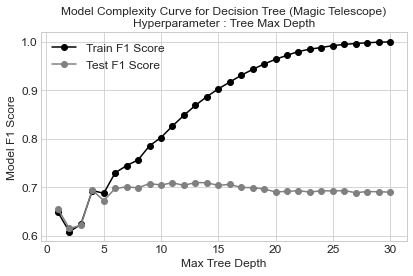

Best Prunning Parameters Based on Hyperparameter Tuning
*******************************************************
{'max_depth': 10}
*******************************************************


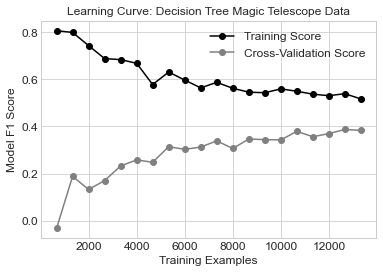

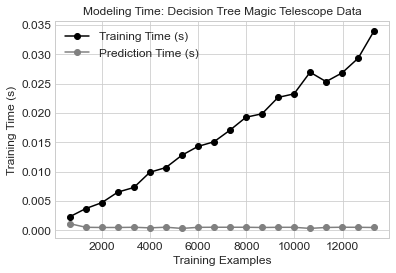

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.02827
Model Prediction Time (s): 0.00058

r2:  0.20
*****************************************************


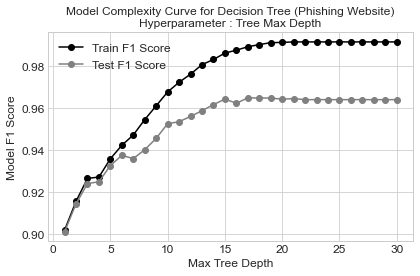

Best Prunning Parameters Based on Hyperparameter Tuning
*******************************************************
{'max_depth': 23}
*******************************************************


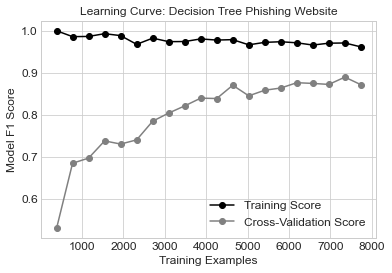

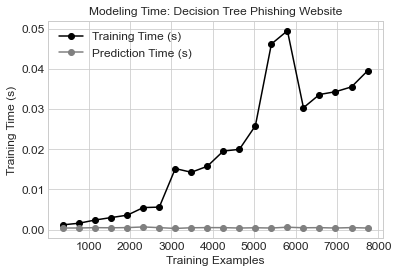

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.01450
Model Prediction Time (s): 0.00054

r2:  0.84
*****************************************************


In [12]:
telescopeX,telescopeY,phishingX,phishingY = import_data()

X_train, X_test, y_train, y_test = train_test_split(np.array(telescopeX),np.array(telescopeY), test_size=0.30)
hyperTree(X_train, y_train, X_test, y_test,title="Model Complexity Curve for Decision Tree (Magic Telescope)\nHyperparameter : Tree Max Depth")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth = TreeGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
estimator_MT = DecisionTreeClassifier(max_depth=max_depth, random_state=100, criterion='gini')
train_samp_MT, DT_train_score_MT, DT_fit_time_MT, DT_pred_time_MT, DT_cv_mean_MT = plot_learning_curve(estimator_MT, X_train, y_train,title="Decision Tree Magic Telescope Data")
final_classifier_evaluation(estimator_MT, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(np.array(phishingX),np.array(phishingY), test_size=0.30)
hyperTree(X_train, y_train, X_test, y_test,title="Model Complexity Curve for Decision Tree (Phishing Website)\nHyperparameter : Tree Max Depth")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth = TreeGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
estimator_PW = DecisionTreeClassifier(max_depth=max_depth, random_state=100, criterion='gini')
train_samp_PW, DT_train_score_PW, DT_fit_time_PW, DT_pred_time_PW, DT_cv_mean_PW = plot_learning_curve(estimator_PW, X_train, y_train,title="Decision Tree Phishing Website")
final_classifier_evaluation(estimator_PW, X_train, X_test, y_train, y_test)

# Boosted Decision Tree Classifier

This section will implement a boosted version of the earlier decision tree. We will still keep the pruning based on max_depth and min_samples_leaf, but the cutoff thresholds will be more aggressive (lower) since the power of boosting is to combine multiple weak learners. We also introduce the hyperparameter of n_estimators and learning rate which will determine the contribution of each tree classifier.

In [13]:
from sklearn.ensemble import AdaBoostClassifier

def hyperBoost1(X_train, y_train, X_test, y_test, max_depth, min_samples_leaf, title):
    
    f1_test = []
    f1_train = []
    n_estimators = np.linspace(1,500,40).astype('int')
    tree = DecisionTreeClassifier(criterion='gini', random_state=100, max_depth=1)
    for i in n_estimators:         
            clf = AdaBoostClassifier(base_estimator=tree, n_estimators=i, random_state=100,)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(n_estimators, f1_train, 'o-', color = 'black', label='Train F1 Score')
    plt.plot(n_estimators, f1_test, 'o-', color='grey', label='Test F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Estimators')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def hyperBoost2(X_train, y_train, X_test, y_test, max_depth, min_samples_leaf, title):
    
    f1_test = []
    f1_train = []
    l_rate = np.linspace(.0001,0.3,22).round(4)
    tree = DecisionTreeClassifier(criterion='gini', random_state=100, max_depth=1)
    for i in l_rate:         
            clf = AdaBoostClassifier(base_estimator=tree, learning_rate = i, n_estimators=500, random_state=100,)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
    
    plt.plot(l_rate, f1_train, 'o-', color = 'black', label='Train F1 Score')
    plt.plot(l_rate, f1_test, 'o-', color='grey', label='Test F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Learning Rate')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
def BoostedGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    param_grid = {'n_estimators': np.linspace(10,500,10).round().astype('int'),
                  'learning_rate': np.linspace(.0001,0.3,22).round(4)}

    boost = GridSearchCV(estimator = AdaBoostClassifier(), param_grid=param_grid, cv=10)
    boost.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)
    return boost.best_params_['n_estimators'], boost.best_params_['learning_rate']

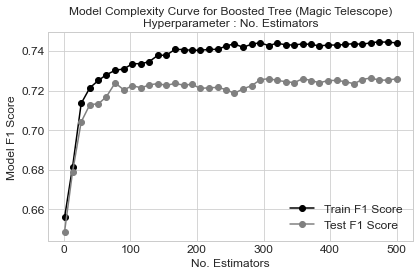

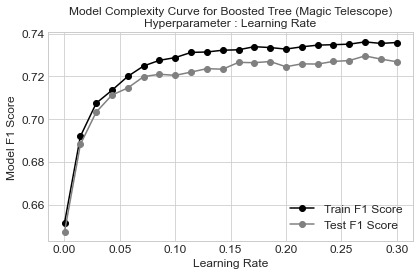

Per Hyperparameter tuning, best parameters are:
{'learning_rate': 0.2714, 'n_estimators': 337}


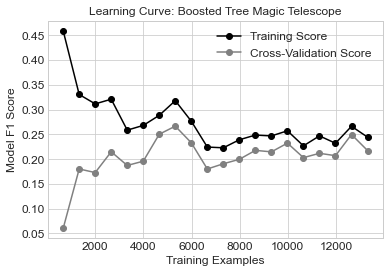

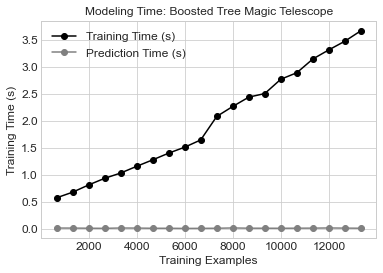

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   1.93259
Model Prediction Time (s): 0.16125

r2:  0.23
*****************************************************


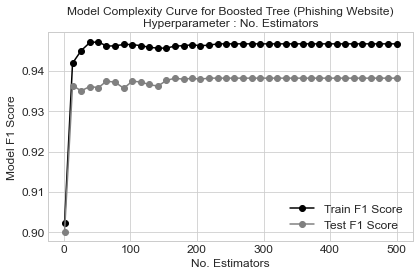

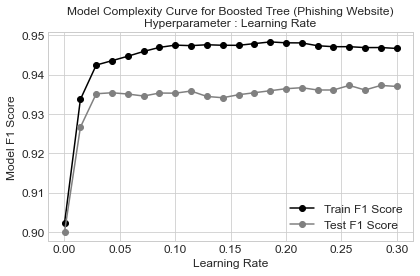

Per Hyperparameter tuning, best parameters are:
{'learning_rate': 0.3, 'n_estimators': 228}


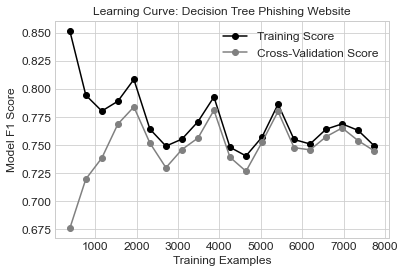

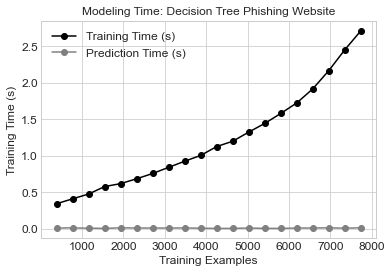

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.96628
Model Prediction Time (s): 0.08027

r2:  0.71
*****************************************************


In [14]:
telescopeX,telescopeY,phishingX,phishingY = import_data()

X_train, X_test, y_train, y_test = train_test_split(np.array(telescopeX),np.array(telescopeY), test_size=0.30)
hyperBoost1(X_train, y_train, X_test, y_test, 3, 50, title="Model Complexity Curve for Boosted Tree (Magic Telescope)\nHyperparameter : No. Estimators")
hyperBoost2(X_train, y_train, X_test, y_test, 3, 50, title="Model Complexity Curve for Boosted Tree (Magic Telescope)\nHyperparameter : Learning Rate")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]
n_est, learn_rate = BoostedGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
tree = DecisionTreeClassifier(criterion='gini', random_state=100, max_depth=1)
estimator_MT = AdaBoostClassifier(base_estimator=tree, n_estimators=n_est, learning_rate=learn_rate, random_state=100)
train_samp_MT, BT_train_score_MT, BT_fit_time_MT, BT_pred_time_MT, BT_cv_mean_MT = plot_learning_curve(estimator_MT, X_train, y_train,title="Boosted Tree Magic Telescope")
final_classifier_evaluation(estimator_MT, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(np.array(phishingX),np.array(phishingY), test_size=0.30)
hyperBoost1(X_train, y_train, X_test, y_test, 3, 50, title="Model Complexity Curve for Boosted Tree (Phishing Website)\nHyperparameter : No. Estimators")
hyperBoost2(X_train, y_train, X_test, y_test, 3, 50, title="Model Complexity Curve for Boosted Tree (Phishing Website)\nHyperparameter : Learning Rate")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]
n_est, learn_rate = BoostedGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
tree = DecisionTreeClassifier(criterion='gini', random_state=100, max_depth=1)
estimator_PW = AdaBoostClassifier(base_estimator=tree, n_estimators=n_est, learning_rate=learn_rate, random_state=100)
train_samp_PW, BT_train_score_PW, BT_fit_time_PW, BT_pred_time_PW, BT_cv_mean_PW = plot_learning_curve(estimator_PW, X_train, y_train,title="Decision Tree Phishing Website")
final_classifier_evaluation(estimator_PW, X_train, X_test, y_train, y_test)

# Neural Network Classifier

This section will build a forward-feed neural network which computes weights via backpropagation (a multilayer perceptron). The main hyperparameter will be number of hidden nodes in a network defined by a single hidden layer, while others that could be searched over in grid search are activation function, and learning rate.

In [10]:
from sklearn.neural_network import MLPClassifier

def hyperNN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    hlist = np.linspace(1,150,30).astype('int')
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic', 
                                learning_rate_init=0.05, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(hlist, f1_train, 'o-', color = 'black', label='Train F1 Score')
    plt.plot(hlist, f1_test, 'o-', color='grey', label='Test F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def hyperNN2(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    l_rate = np.linspace(.001,0.3,22).round(3)
    for i in l_rate:         
            clf = MLPClassifier(hidden_layer_sizes=(10,), solver='adam', activation='logistic', 
                                learning_rate_init= i , random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(l_rate, f1_train, 'o-', color = 'black', label='Train F1 Score')
    plt.plot(l_rate, f1_test, 'o-', color='grey', label='Test F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Learning Rate')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()   
    
def NNGridSearchCV(X_train, y_train):
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    learning_rates = [0.01, 0.05, .1]
    param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',random_state=100),
                       param_grid=param_grid, cv=10)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes'], net.best_params_['learning_rate_init']

C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


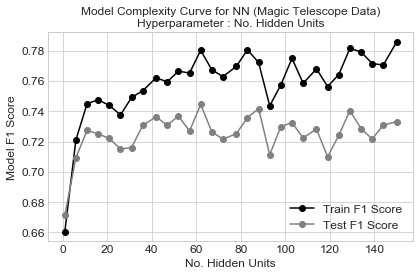

C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


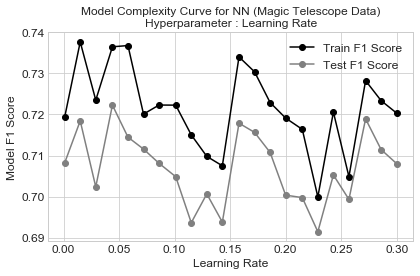

C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

Per Hyperparameter tuning, best parameters are:
{'hidden_layer_sizes': 100, 'learning_rate_init': 0.05}


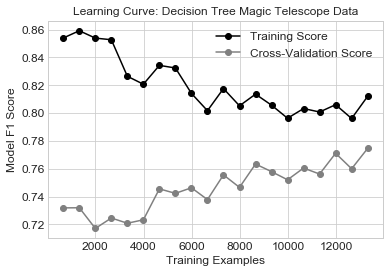

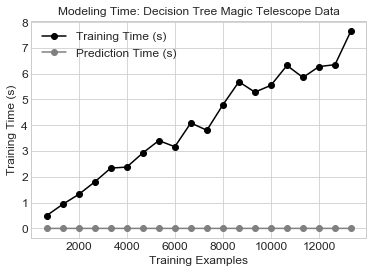

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.87332
Model Prediction Time (s): 0.00642

F1 Score:  0.74
Accuracy:  0.82     AUC:       0.79
Precision: 0.78     Recall:    0.69
*****************************************************


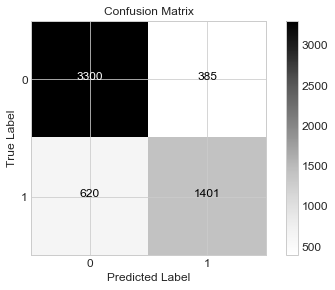

C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


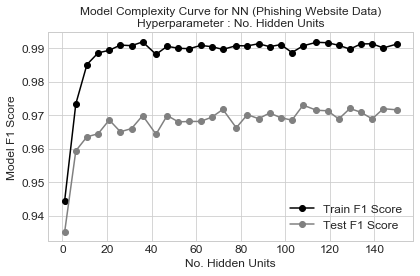

C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


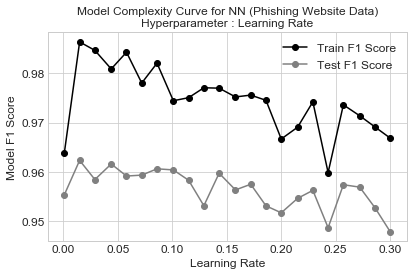

C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

Per Hyperparameter tuning, best parameters are:
{'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}


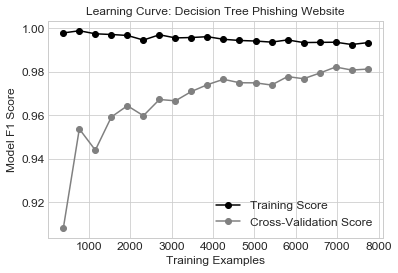

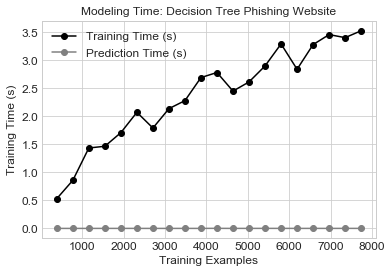

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   1.42062
Model Prediction Time (s): 0.00568

F1 Score:  0.97
Accuracy:  0.97     AUC:       0.97
Precision: 0.96     Recall:    0.98
*****************************************************


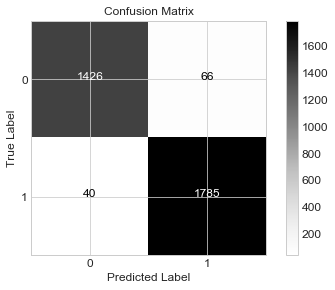

In [11]:
telescopeX,telescopeY,phishingX,phishingY = import_data()

X_train, X_test, y_train, y_test = train_test_split(np.array(telescopeX),np.array(telescopeY), test_size=0.30)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
hyperNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for NN (Magic Telescope Data)\nHyperparameter : No. Hidden Units")
hyperNN2(X_train, y_train, X_test, y_test,title="Model Complexity Curve for NN (Magic Telescope Data)\nHyperparameter : Learning Rate")
h_units, learn_rate = NNGridSearchCV(X_train, y_train)
estimator_MT = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', 
                               learning_rate_init=learn_rate, random_state=100)
train_samp_MT, NN_train_score_MT, NN_fit_time_MT, NN_pred_time_MT, NN_cv_mean_MT = plot_learning_curve(estimator_MT, X_train, y_train,title="Decision Tree Magic Telescope Data")
final_classifier_evaluation(estimator_MT, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(np.array(phishingX),np.array(phishingY), test_size=0.30)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
hyperNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for NN (Phishing Website Data)\nHyperparameter : No. Hidden Units")
hyperNN2(X_train, y_train, X_test, y_test,title="Model Complexity Curve for NN (Phishing Website Data)\nHyperparameter : Learning Rate")
h_units, learn_rate = NNGridSearchCV(X_train, y_train)
estimator_PW = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', 
                               learning_rate_init=learn_rate, random_state=100)
train_samp_PW, NN_train_score_PW, NN_fit_time_PW, NN_pred_time_PW, NN_cv_mean_PW = plot_learning_curve(estimator_PW, X_train, y_train,title="Decision Tree Phishing Website")
final_classifier_evaluation(estimator_PW, X_train, X_test, y_train, y_test)

The final section for neural network will plot the loss curve for each dataset over the iterations.

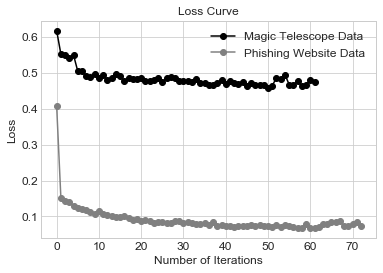

In [12]:
telescopeX,telescopeY,phishingX,phishingY = import_data()

X_train, X_test, y_train, y_test = train_test_split(np.array(telescopeX),np.array(telescopeY), test_size=0.30)
estimator_MT = MLPClassifier(hidden_layer_sizes=(75,), solver='adam', activation='logistic', 
                               learning_rate_init=0.1, random_state=100)
estimator_MT.fit(X_train, y_train)
a = estimator_MT.loss_curve_

X_train, X_test, y_train, y_test = train_test_split(np.array(phishingX),np.array(phishingY), test_size=0.30)
estimator_PW = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', 
                               learning_rate_init=0.1, random_state=100)
estimator_PW.fit(X_train, y_train)
b = estimator_PW.loss_curve_

plt.figure()
plt.title("Loss Curve")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.plot(a, 'o-', color="black", label="Magic Telescope Data")
plt.plot(b, 'o-', color="grey", label="Phishing Website Data")
plt.legend(loc="best")
plt.show()

This section will create a surface plot for the Phishing data to see where the local and global maxima occur for different numbers of hidden units for a network with 2 hidden layers.

# KNN Classifier

This section will build a classifier using K-nearest neighbors. The hyperparameter will be n_neighbors. One could easily add another hyperparameter is the distance metric, but for simplicity, and for the sake of running the code faster, I won't explore this. I will use the standard euclidean distance for all models. The Model Complexity curve will show F1 score as a function of number of neighbors.

In [13]:
from sklearn.neighbors import KNeighborsClassifier as kNN

def hyperKNN(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    klist = np.linspace(1,250,25).astype('int')
    for i in klist:
        clf = kNN(n_neighbors=i,n_jobs=-1, weights = "distance")
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f1_train, 'o-', color = 'black', label='Train F1 Score')
    plt.plot(klist, f1_test, 'o-', color='grey', label='Test F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Neighbors')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    

def kNNGridSearchCV(X_train, y_train):
    neighbors = np.linspace(1,250,25).astype('int')
    distance = [1, 2]
    param_grid = {'n_neighbors': neighbors, 'p': distance}

    knn = GridSearchCV(estimator = kNN(n_jobs=-1, weights = "distance"),
                       param_grid=param_grid, cv=10)
    knn.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(knn.best_params_)
    return knn.best_params_['n_neighbors'], knn.best_params_['p']

C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


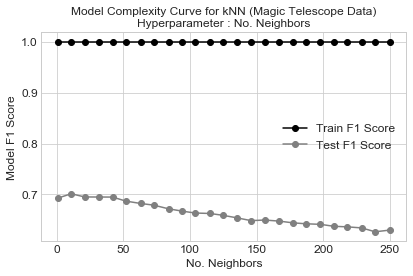

Per Hyperparameter tuning, best parameters are:
{'n_neighbors': 11, 'p': 1}


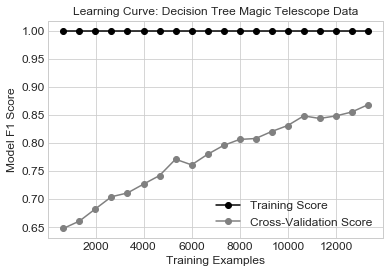

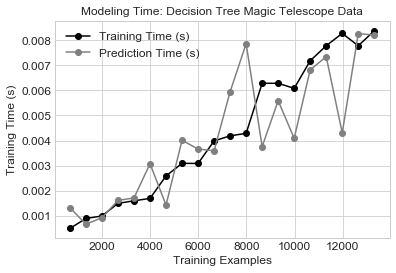

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.00646
Model Prediction Time (s): 0.10493

F1 Score:  0.69
Accuracy:  0.79     AUC:       0.76
Precision: 0.74     Recall:    0.64
*****************************************************


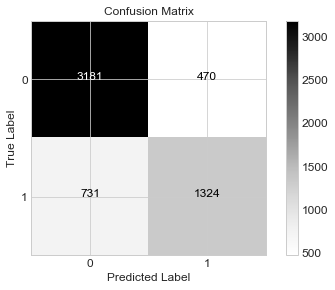

C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


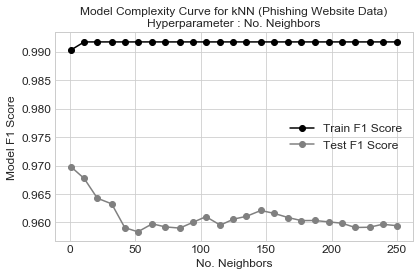

Per Hyperparameter tuning, best parameters are:
{'n_neighbors': 1, 'p': 2}


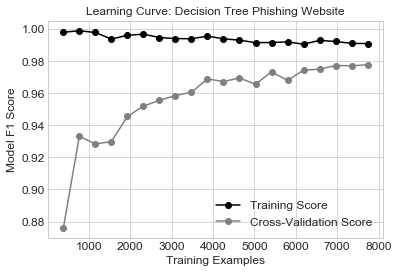

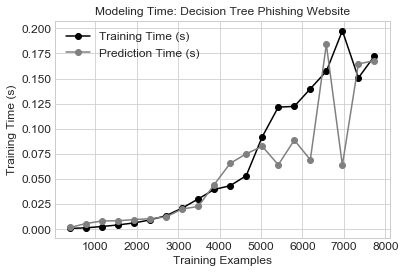

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.08161
Model Prediction Time (s): 0.44051

F1 Score:  0.97
Accuracy:  0.97     AUC:       0.96
Precision: 0.97     Recall:    0.97
*****************************************************


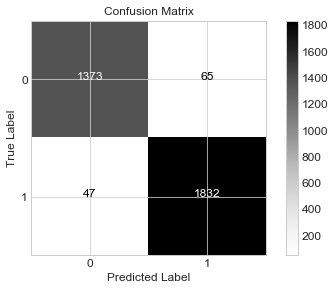

In [14]:
telescopeX,telescopeY,phishingX,phishingY = import_data()

X_train, X_test, y_train, y_test = train_test_split(np.array(telescopeX),np.array(telescopeY), test_size=0.30)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
hyperKNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for kNN (Magic Telescope Data)\nHyperparameter : No. Neighbors")
neighbors, distance= kNNGridSearchCV(X_train, y_train)
estimator_MT = kNN(n_neighbors=distance, p = distance, n_jobs=-1, weights = "distance")
train_samp_MT, kNN_train_score_MT, kNN_fit_time_MT, kNN_pred_time_MT, kNN_cv_mean_MT = plot_learning_curve(estimator_MT, X_train, y_train,title="Decision Tree Magic Telescope Data")
final_classifier_evaluation(estimator_MT, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(np.array(phishingX),np.array(phishingY), test_size=0.30)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
hyperKNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for kNN (Phishing Website Data)\nHyperparameter : No. Neighbors")
neighbors, distance= kNNGridSearchCV(X_train, y_train)
estimator_PW = kNN(n_neighbors=distance, p = distance, n_jobs=-1, weights = "distance")
train_samp_PW, kNN_train_score_PW, kNN_fit_time_PW, kNN_pred_time_PW, kNN_cv_mean_PW = plot_learning_curve(estimator_PW, X_train, y_train,title="Decision Tree Phishing Website")
final_classifier_evaluation(estimator_PW, X_train, X_test, y_train, y_test)

# Support Vector Machine Classifier

This section will build a support vector machine classifier. The primary hyperparameter will be kernel function: linear, polynomial, rbf (radial basis function), and sigmoid. We will also explore the penalty term 'C' and the kernel coefficient 'gamma'.

In [15]:
from sklearn.svm import SVC

def hyperSVM(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    kernel_func = ['linear','poly','rbf','sigmoid']
    for i in kernel_func:         
            if i == 'poly':
                for j in [2,3,4,5,6,7,8]:
                    clf = SVC(kernel=i, degree=j,random_state=100)
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    f1_test.append(f1_score(y_test, y_pred_test))
                    f1_train.append(f1_score(y_train, y_pred_train))
            else:    
                clf = SVC(kernel=i, random_state=100)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                f1_test.append(f1_score(y_test, y_pred_test))
                f1_train.append(f1_score(y_train, y_pred_train))
                
    xvals = ['linear','poly2','poly3','poly4','poly5','poly6','poly7','poly8','rbf','sigmoid']

    plt.plot(xvals, f1_train, 'o-', color = 'black', label='Train F1 Score')
    plt.plot(xvals, f1_test, 'o-', color='grey', label='Test F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Kernel Function')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
def SVMGridSearchCV(X_train, y_train):
    Cs = [1e-4, 1e-3, 1e-2, 1e01, 1]
    gammas = [0.1,1,10,100]
    param_grid = {'C': Cs, 'gamma': gammas}

    clf = GridSearchCV(estimator = SVC(kernel='rbf',random_state=100),
                       param_grid=param_grid, cv=10)
    clf.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(clf.best_params_)
    return clf.best_params_['C'], clf.best_params_['gamma']

C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklea

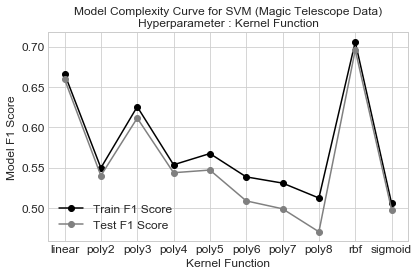

Per Hyperparameter tuning, best parameters are:
{'C': 10.0, 'gamma': 1}


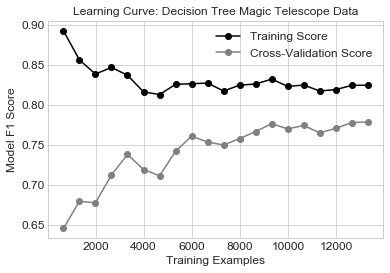

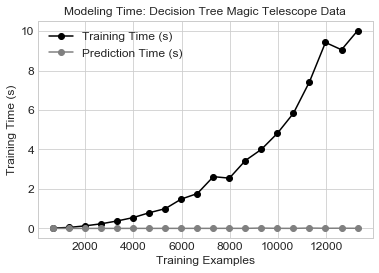

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.47827
Model Prediction Time (s): 0.52104

F1 Score:  0.71
Accuracy:  0.83     AUC:       0.78
Precision: 0.83     Recall:    0.62
*****************************************************


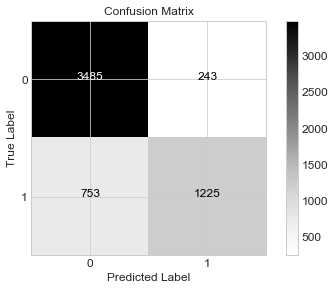

C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bosun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


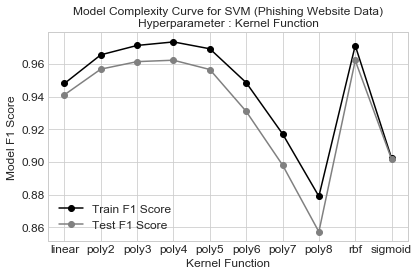

Per Hyperparameter tuning, best parameters are:
{'C': 10.0, 'gamma': 0.1}


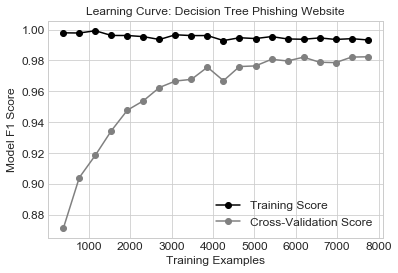

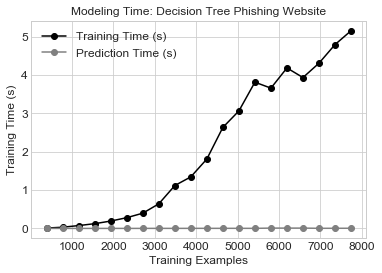

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   1.83284
Model Prediction Time (s): 0.49879

F1 Score:  0.98
Accuracy:  0.97     AUC:       0.97
Precision: 0.97     Recall:    0.98
*****************************************************


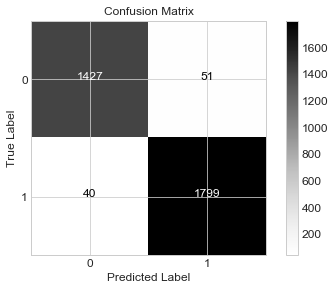

In [16]:
telescopeX,telescopeY,phishingX,phishingY = import_data()

X_train, X_test, y_train, y_test = train_test_split(np.array(telescopeX),np.array(telescopeY), test_size=0.30)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
hyperSVM(X_train, y_train, X_test, y_test,title="Model Complexity Curve for SVM (Magic Telescope Data)\nHyperparameter : Kernel Function")
C_val, gamma_val = SVMGridSearchCV(X_train, y_train)
estimator_MT = SVC(C=C_val, gamma=gamma_val, kernel='rbf', random_state=100)
train_samp_MT, SVM_train_score_MT, SVM_fit_time_MT, SVM_pred_time_MT, SVM_cv_mean_MT = plot_learning_curve(estimator_MT, X_train, y_train,title="Decision Tree Magic Telescope Data")
final_classifier_evaluation(estimator_MT, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(np.array(phishingX),np.array(phishingY), test_size=0.30)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
hyperSVM(X_train, y_train, X_test, y_test,title="Model Complexity Curve for SVM (Phishing Website Data)\nHyperparameter : Kernel Function")
C_val, gamma_val = SVMGridSearchCV(X_train, y_train)
estimator_PW = SVC(C=C_val, gamma=gamma_val, kernel='rbf', random_state=100)
train_samp_PW, SVM_train_score_PW, SVM_fit_time_PW, SVM_pred_time_PW, SVM_cv_mean_PW = plot_learning_curve(estimator_PW, X_train, y_train,title="Decision Tree Phishing Website")
final_classifier_evaluation(estimator_PW, X_train, X_test, y_train, y_test)

# 4. Model Comparison Plots

Finally, let's define and call a function that will plot training times and learning rates for the 5 different algorithms so that we can compare across the classifiers for the same dataset.

In [17]:
def compare_fit_time(n,NNtime, SMVtime, kNNtime, DTtime, BTtime, title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, NNtime, '-', color="b", label="Neural Network")
    plt.plot(n, SMVtime, '-', color="r", label="SVM")
    plt.plot(n, kNNtime, '-', color="g", label="kNN")
    plt.plot(n, DTtime, '-', color="m", label="Decision Tree")
    plt.plot(n, BTtime, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,NNpred, SMVpred, kNNpred, DTpred, BTpred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, NNpred, '-', color="b", label="Neural Network")
    plt.plot(n, SMVpred, '-', color="r", label="SVM")
    plt.plot(n, kNNpred, '-', color="g", label="kNN")
    plt.plot(n, DTpred, '-', color="m", label="Decision Tree")
    plt.plot(n, BTpred, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()


def compare_learn_time(n,NNlearn, SMVlearn, kNNlearn, DTlearn, BTlearn, title):
    
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(n, NNlearn, '-', color="b", label="Neural Network")
    plt.plot(n, SMVlearn, '-', color="r", label="SVM")
    plt.plot(n, kNNlearn, '-', color="g", label="kNN")
    plt.plot(n, DTlearn, '-', color="m", label="Decision Tree")
    plt.plot(n, BTlearn, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show() 

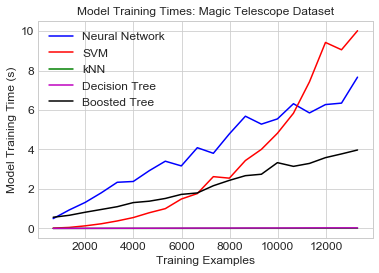

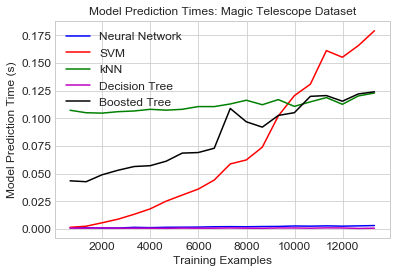

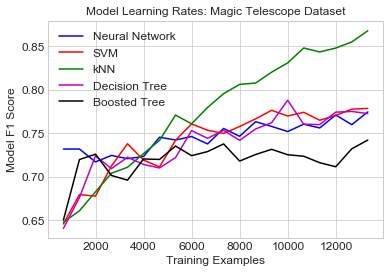

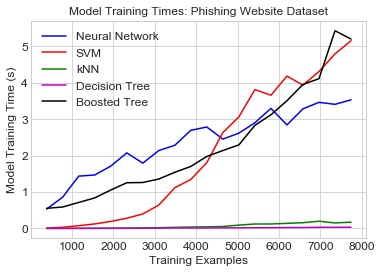

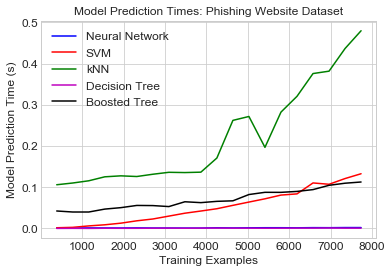

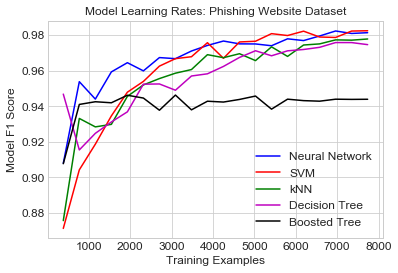

In [18]:
compare_fit_time(train_samp_MT, NN_fit_time_MT, SVM_fit_time_MT, kNN_fit_time_MT, 
                 DT_fit_time_MT, BT_fit_time_MT, 'Magic Telescope Dataset')              
compare_pred_time(train_samp_MT, NN_pred_time_MT, SVM_pred_time_MT, kNN_pred_time_MT, 
                 DT_pred_time_MT, BT_pred_time_MT, 'Magic Telescope Dataset')   
compare_learn_time(train_samp_MT, NN_cv_mean_MT, SVM_cv_mean_MT, kNN_cv_mean_MT, 
                 DT_cv_mean_MT, BT_cv_mean_MT, 'Magic Telescope Dataset')  



compare_fit_time(train_samp_PW, NN_fit_time_PW, SVM_fit_time_PW, kNN_fit_time_PW, 
                 DT_fit_time_PW, BT_fit_time_PW, 'Phishing Website Dataset')       
compare_pred_time(train_samp_PW, NN_pred_time_PW, SVM_pred_time_PW, kNN_pred_time_PW, 
                 DT_pred_time_PW, BT_pred_time_PW, 'Phishing Website Dataset')           
compare_learn_time(train_samp_PW, NN_cv_mean_PW, SVM_cv_mean_PW, kNN_cv_mean_PW, 
                 DT_cv_mean_PW, BT_cv_mean_PW, 'Phishing Website Dataset')